In [14]:
import alg
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import dalex as dx

df_raw = pd.read_csv("https://raw.githubusercontent.com/Foroughp/Manipulating-and-Measuring-Model-Interpretability/master/data/apartments/all_apartments.csv")
df = df_raw.rename(columns={'price': 'target'})
df = df.assign(bedrooms=df.bedrooms.astype(int), baths=df.baths.astype(int)).loc[: , df.columns.sort_values()]
df.head()

,baths,bedrooms,days_on_the_market,maintenance_fee,school_distance,sqft,subway_distance,target,total_rooms
0,1,2,0,1370,0.262,1240,0.0806,999000,4.5
1,3,3,0,1520,0.334,1800,0.1010,2400000,6.0
2,1,1,0,598,0.278,900,0.1220,1300000,3.5
3,1,1,0,746,0.386,500,0.1560,395000,3.0
4,1,1,0,510,0.278,702,0.1220,775000,3.0


In [15]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile.to_widgets()

In [16]:
X, y = df.drop(["target"], axis=1), df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
model = xgboost.XGBRegressor(n_estimators=150, max_depth=5, random_state=0).fit(X_train, y_train)
explainer = alg.Explainer(model, X_test)
import dalex as dx
e = dx.Explainer(model, X_test, y_test, verbose=False)
e.model_performance()

,mse,rmse,r2,mae,mad
XGBRegressor,5.070253e+10,225172.225878,0.854415,176955.278093,145955.5625


In [17]:
pd.DataFrame({'variable': X.columns, 'importance_split': model.feature_importances_,
              'importance_shap': explainer.shap_values(explainer.data),
              'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})

,variable,importance_split,importance_shap,importance_perm
7,baths,0.509714,104219.497412,320263.709289
6,bedrooms,0.016971,71848.561000,274657.265149
0,days_on_the_market,0.004838,38927.680738,219678.816193
3,maintenance_fee,0.008277,41946.053308,233933.138572
4,school_distance,0.015384,37827.956345,239960.705326
8,sqft,0.401121,332773.217782,631442.856572
5,subway_distance,0.022532,31437.528855,240081.462380
2,total_rooms,0.021162,20438.730477,227236.371265


In [18]:
a = alg.GeneticAlgorithm(explainer, constant=["bedrooms", "baths"], pop_count=100, alpha=0.75)
t = a.explainer.shap_values(a._X)
tt = t.copy()
t = np.array([150000 for _ in t])
pd.DataFrame({'original': tt, 'target': t})

,original,target
0,104219.497412,150000
1,71848.561000,150000
2,38927.680738,150000
3,41946.053308,150000
4,37827.956345,150000
5,332773.217782,150000
6,31437.528855,150000
7,20438.730477,150000


In [19]:
a.fool_aim(target=t, max_iter=400, random_state=0)

Iter: 400 || Loss: 0.4024722115526309: 100%|██████████| 400/400 [8:34:28<00:00, 77.17s/it]


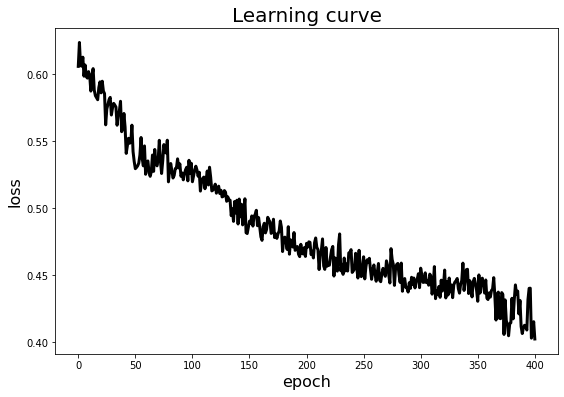

In [20]:
a.plot_losses()

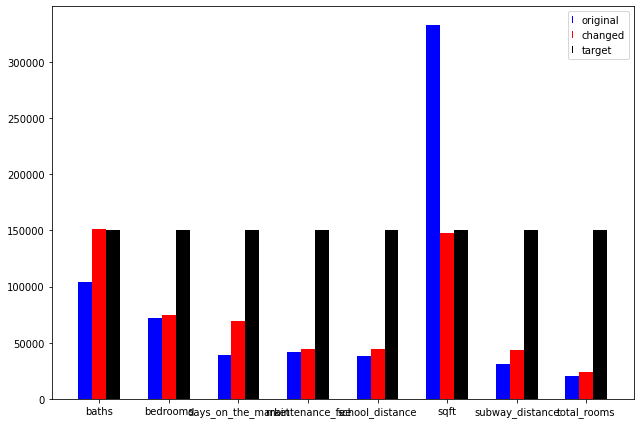

In [21]:
a.plot_explanation()

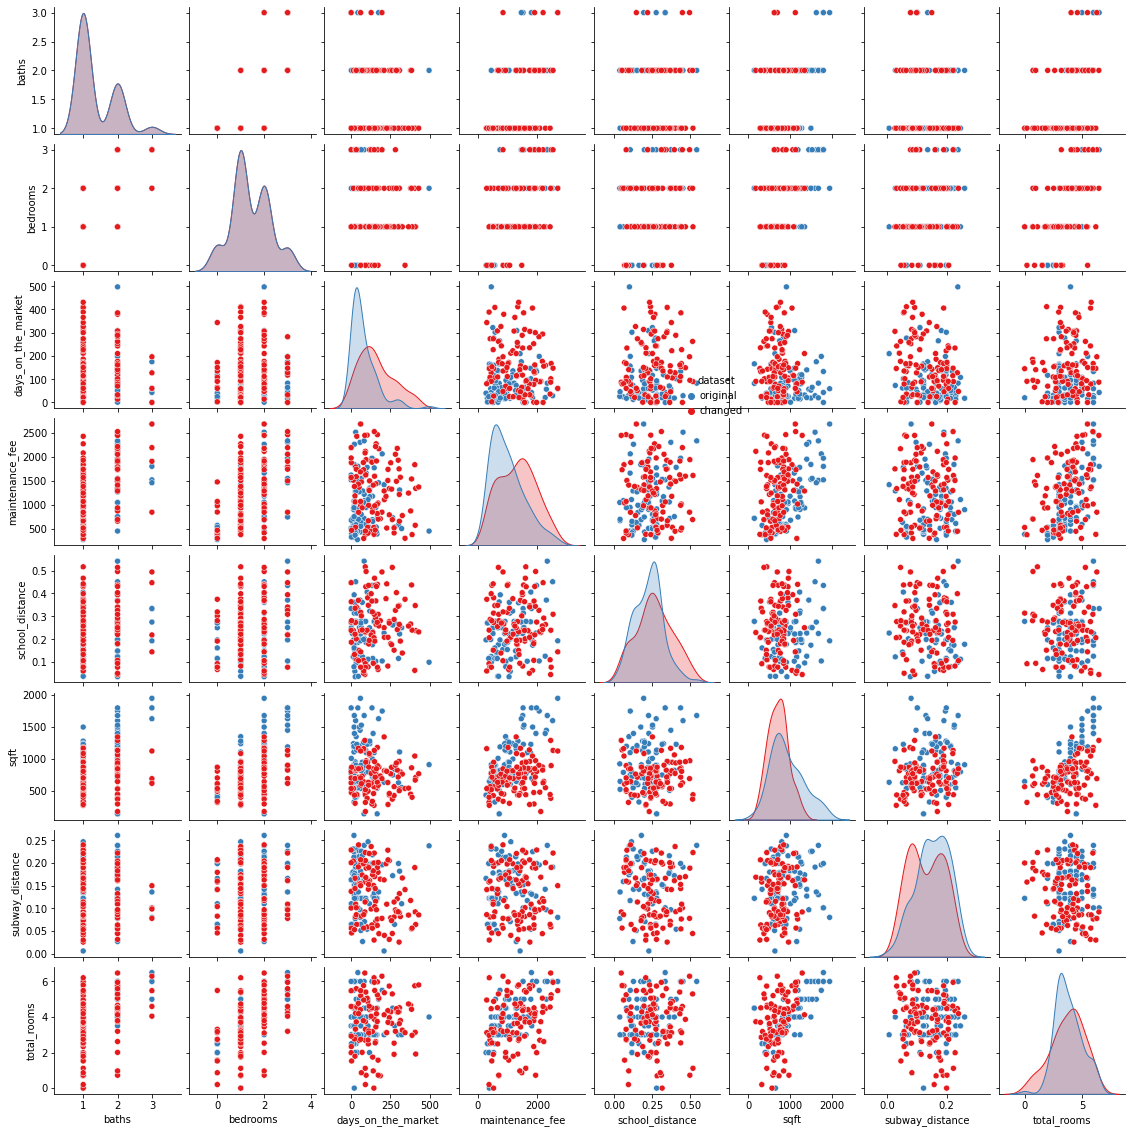

In [22]:
a.plot_data()

In [23]:
import pickle
pickle.dump(a.result_explanation, open("results/final-apartment-global_explanation.p", "wb") )
pickle.dump(a.result_data, open("results/final-apartment-global_data.p", "wb" ) )
pickle.dump(a.iter_losses, open("results/final-apartment-global_losses.p", "wb") )